In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2  # Volvemos a un modelo más simple y estable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible y configurada")
else:
    print("Usando CPU")

GPU disponible y configurada


In [ ]:
# Download dataset
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
path = os.path.join(path, 'garbage-dataset')
print("Path to dataset files:", path)

# Materiales de interés
materiales_interes = ['glass', 'plastic', 'metal']

# Verificar que las carpetas existen
print("Verificando estructura del dataset:")
for material in materiales_interes:
    material_path = os.path.join(path, material)
    if os.path.exists(material_path):
        count = len(os.listdir(material_path))
        print(f"✅ {material}: {count} imágenes")
    else:
        print(f"❌ {material}: Carpeta no encontrada")

Path to dataset files: /kaggle/input/garbage-classification-v2/garbage-dataset
Verificando estructura del dataset:
✅ glass: 3061 imágenes
✅ plastic: 1984 imágenes
✅ metal: 1020 imágenes


In [ ]:
# CONFIGURACIÓN CORREGIDA
IMG_SIZE = (224, 224)  # Volvemos al tamaño estándar
BATCH_SIZE = 16        # Batch size más pequeño para estabilidad
NUM_CLASSES = len(materiales_interes)

print(f"\nConfiguración:")
print(f"Tamaño de imagen: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Número de clases: {NUM_CLASSES}")

# DATA AUGMENTATION MÁS CONSERVADOR
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Reducido
    width_shift_range=0.1,      # Reducido
    height_shift_range=0.1,     # Reducido
    shear_range=0.1,            # Reducido
    zoom_range=0.1,             # Reducido
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2        # Split estándar
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generadores
train_gen = train_datagen.flow_from_directory(
    path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=materiales_interes,
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = val_test_datagen.flow_from_directory(
    path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=materiales_interes,
    subset='validation',
    shuffle=True,
    seed=42
)

test_gen = val_test_datagen.flow_from_directory(
    path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=materiales_interes,
    subset='validation',
    shuffle=False,
    seed=42
)



Configuración:
Tamaño de imagen: (224, 224)
Batch size: 16
Número de clases: 3
Found 4853 images belonging to 3 classes.
Found 1212 images belonging to 3 classes.
Found 1212 images belonging to 3 classes.


In [ ]:
print(f"\n📊 Distribución de datos:")
print(f"Entrenamiento: {train_gen.samples} imágenes")
print(f"Validación: {val_gen.samples} imágenes")
print(f"Steps por época: {train_gen.samples // BATCH_SIZE}")

class_names = list(train_gen.class_indices.keys())
print(f"Clases: {class_names}")


📊 Distribución de datos:
Entrenamiento: 4853 imágenes
Validación: 1212 imágenes
Steps por época: 303
Clases: ['glass', 'plastic', 'metal']


In [ ]:
def check_class_distribution(generator, name):
    """Verificar distribución de clases"""
    print(f"\n🔍 Distribución de clases en {name}:")
    class_counts = {}

    # Resetear generador
    generator.reset()
    steps = len(generator)

    for step in range(min(steps, 10)):  # Verificar solo primeros 10 batches
        batch_x, batch_y = next(generator)
        batch_classes = np.argmax(batch_y, axis=1)

        for class_idx in batch_classes:
            class_name = class_names[class_idx]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count}")

    generator.reset()
    return class_counts

In [ ]:
# Verificar distribución
train_dist = check_class_distribution(train_gen, "Entrenamiento")
val_dist = check_class_distribution(val_gen, "Validación")

# MODELO SIMPLIFICADO Y ESTABLE
def create_stable_model(input_shape=(224, 224, 3), num_classes=3):
    """
    Crear un modelo estable y simple
    """
    # Modelo base MobileNetV2 (probado y estable)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Congelar completamente el modelo base
    base_model.trainable = False

    # Modelo completo
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    return model, base_model


🔍 Distribución de clases en Entrenamiento:
  plastic: 50
  glass: 82
  metal: 28

🔍 Distribución de clases en Validación:
  plastic: 47
  glass: 88
  metal: 25


In [ ]:
# Crear modelo
print("\n🏗️ Creando modelo...")
model, base_model = create_stable_model(
    input_shape=(*IMG_SIZE, 3),
    num_classes=NUM_CLASSES
)
print("Arquitectura del modelo:")
model.summary()


🏗️ Creando modelo...
Arquitectura del modelo:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,971 (9.26 MB)

 Trainable params: 167,171 (653.01 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [ ]:
# COMPILACIÓN CONSERVADORA
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # LR más bajo
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Solo accuracy básica por ahora
)

In [ ]:
# CALLBACKS MEJORADOS
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        'best_model.keras',  # Formato moderno
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]


In [ ]:
# FUNCIÓN DE DIAGNÓSTICO
def diagnostic_training(model, train_gen, val_gen, epochs=3):
    """
    Entrenamiento diagnóstico para detectar problemas
    """
    print("🔬 DIAGNÓSTICO INICIAL (3 epochs)")

    # Verificar un batch
    print("\n📋 Verificando primer batch:")
    train_gen.reset()
    batch_x, batch_y = next(train_gen)

    print(f"Forma del batch X: {batch_x.shape}")
    print(f"Forma del batch Y: {batch_y.shape}")
    print(f"Rango de valores X: [{batch_x.min():.3f}, {batch_x.max():.3f}]")
    print(f"Suma de Y (debe ser 1 por muestra): {batch_y.sum(axis=1)[:5]}")

    # Predicción inicial
    initial_pred = model.predict(batch_x[:5], verbose=0)
    print(f"Predicciones iniciales (primeras 5):")
    for i, pred in enumerate(initial_pred):
        print(f"  Muestra {i}: {pred}")

    # Entrenamiento diagnóstico
    train_gen.reset()
    val_gen.reset()

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=1,
        steps_per_epoch=min(20, train_gen.samples // BATCH_SIZE),  # Pocas steps para diagnóstico
        validation_steps=min(10, val_gen.samples // BATCH_SIZE)
    )

    return history

In [ ]:
# EJECUTAR DIAGNÓSTICO
print("🚀 Iniciando entrenamiento diagnóstico...")
diagnostic_history = diagnostic_training(model, train_gen, val_gen, epochs=3)


🚀 Iniciando entrenamiento diagnóstico...
🔬 DIAGNÓSTICO INICIAL (3 epochs)

📋 Verificando primer batch:
Forma del batch X: (16, 224, 224, 3)
Forma del batch Y: (16, 3)
Rango de valores X: [0.000, 1.000]
Suma de Y (debe ser 1 por muestra): [1. 1. 1. 1. 1.]
Predicciones iniciales (primeras 5):
  Muestra 0: [0.11659589 0.8221406  0.06126342]
  Muestra 1: [0.6547296  0.2060286  0.13924189]
  Muestra 2: [0.7684107  0.19330263 0.03828666]
  Muestra 3: [0.57484156 0.31740183 0.10775666]
  Muestra 4: [0.7313329  0.16142455 0.10724249]


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.4053 - loss: 1.5800 - val_accuracy: 0.4563 - val_loss: 1.0577
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.3525 - loss: 1.3684 - val_accuracy: 0.5750 - val_loss: 0.8696
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.5476 - loss: 0.9995 - val_accuracy: 0.6562 - val_loss: 0.8102


In [ ]:
# ANALIZAR RESULTADOS DEL DIAGNÓSTICO
def analyze_diagnostic(history):
    """Analizar resultados del diagnóstico"""
    print("\n📊 ANÁLISIS DE DIAGNÓSTICO:")

    last_train_acc = history.history['accuracy'][-1]
    last_val_acc = history.history['val_accuracy'][-1]
    last_train_loss = history.history['loss'][-1]
    last_val_loss = history.history['val_loss'][-1]

    print(f"Accuracy final entrenamiento: {last_train_acc:.4f}")
    print(f"Accuracy final validación: {last_val_acc:.4f}")
    print(f"Loss final entrenamiento: {last_train_loss:.4f}")
    print(f"Loss final validación: {last_val_loss:.4f}")

    # Diagnóstico
    if last_val_loss > 10:
        print("⚠️  PROBLEMA: Loss de validación muy alto")
    if last_val_acc < 0.4:
        print("⚠️  PROBLEMA: Accuracy muy baja")
    if abs(last_train_acc - last_val_acc) > 0.3:
        print("⚠️  PROBLEMA: Overfitting detectado")

    # Sugerencias
    if last_val_acc > 0.6:
        print("✅ Modelo funciona bien, continuar entrenamiento")
        return True
    else:
        print("❌ Modelo necesita ajustes")
        return False


📊 ANÁLISIS DE DIAGNÓSTICO:
Accuracy final entrenamiento: 0.5656
Accuracy final validación: 0.6562
Loss final entrenamiento: 0.9822
Loss final validación: 0.8102
✅ Modelo funciona bien, continuar entrenamiento

🎯 ENTRENAMIENTO COMPLETO
Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6470 - loss: 0.8800
Epoch 1: val_accuracy improved from -inf to 0.81436, saving model to best_model.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 84s 277ms/step - accuracy: 0.6472 - loss: 0.8795 - val_accuracy: 0.8144 - val_loss: 0.4992 - learning_rate: 1.0000e-04
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7753 - loss: 0.5953
Epoch 2: val_accuracy improved from 0.81436 to 0.85314, saving model to best_model.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 84s 277ms/step - accuracy: 0.7754 - loss: 0.5952 - val_accuracy: 0.8531 - val_loss: 0.4126 - learning_rate: 1.0000e-04
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8150 - loss: 0.4848
Epoch 3: val_accuracy improve

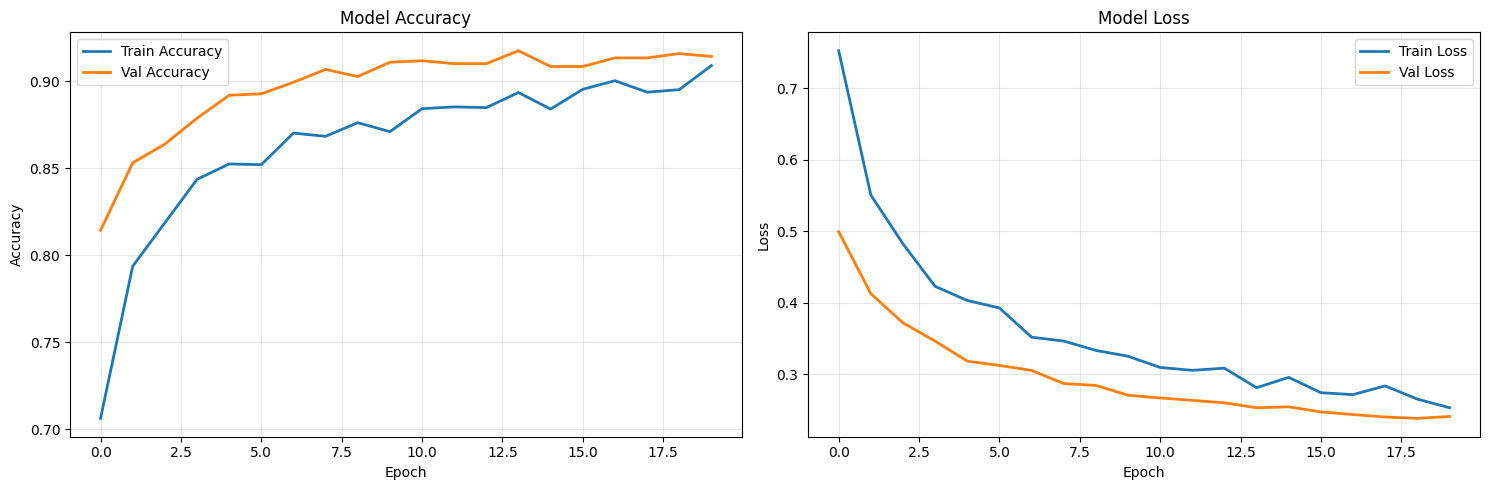


📈 EVALUACIÓN FINAL
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9223 - loss: 0.2472
Test Accuracy: 91.75%

🎯 Generando predicciones...
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       glass     0.9417    0.9232    0.9323       612
     plastic     0.9323    0.9040    0.9179       396
       metal     0.8289    0.9265    0.8750       204

    accuracy                         0.9175      1212
   macro avg     0.9010    0.9179    0.9084      1212
weighted avg     0.9196    0.9175    0.9180      1212



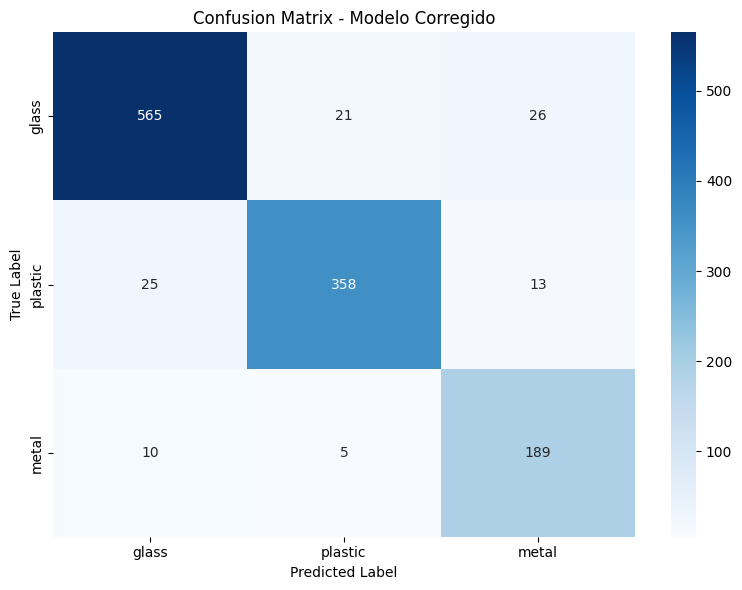

✅ Modelo guardado como 'modelo_corregido_materiales.keras'


In [ ]:
# Analizar diagnóstico
should_continue = analyze_diagnostic(diagnostic_history)

if should_continue:
    print("\n🎯 ENTRENAMIENTO COMPLETO")

    # Resetear generadores
    train_gen.reset()
    val_gen.reset()

    # Entrenamiento completo
    history = model.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    # Gráficas de entrenamiento
    def plot_training_results(history):
        """Graficar resultados del entrenamiento"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy
        ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
        ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loss
        ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
        ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    plot_training_results(history)

    # Evaluación final
    print("\n📈 EVALUACIÓN FINAL")
    test_gen.reset()
    test_results = model.evaluate(test_gen, verbose=1)
    print(f"Test Accuracy: {test_results[1]*100:.2f}%")

    # Predicciones y matriz de confusión
    print("\n🎯 Generando predicciones...")
    test_gen.reset()
    y_pred_probs = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes

    # Reporte de clasificación
    print("\n📋 Reporte de Clasificación:")
    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    )
    print(report)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix - Modelo Corregido')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Guardar modelo
    model.save('modelo_corregido_materiales.keras')
    print("✅ Modelo guardado como 'modelo_corregido_materiales.keras'")

else:
    print("\n🔧 SUGERENCIAS PARA MEJORAR:")
    print("1. Verificar que las imágenes están correctamente etiquetadas")
    print("2. Revisar el balance de clases")
    print("3. Probar con un learning rate aún más bajo (1e-5)")
    print("4. Verificar que las imágenes se cargan correctamente")
    print("5. Considerar usar un modelo pre-entrenado más simple")


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Cargar modelo entrenado
MODEL_PATH = "/content/modelo_corregido_materiales.keras"
model = tf.keras.models.load_model(MODEL_PATH)

# Clases según tu entrenamiento
class_names = ["glass", "plastic", "metal"]

IMG_SIZE = (224, 224)

def predict_image(image):
    # Redimensionar y normalizar
    img = image.resize(IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predicción
    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions)]
    confidence = float(np.max(predictions))

    # Resultado
    return {cls: float(predictions[0][i]) for i, cls in enumerate(class_names)}, f"{pred_class} ({confidence*100:.2f}%)"

# Interfaz Gradio
with gr.Blocks() as demo:
    gr.Markdown("## Clasificación de Materiales (glass / plastic / metal)")

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="Sube una imagen")
            btn = gr.Button("Clasificar")
        with gr.Column():
            label_output = gr.Label(label="Confianza por clase")
            text_output = gr.Textbox(label="Predicción final")

    btn.click(fn=predict_image, inputs=image_input, outputs=[label_output, text_output])

# Ejecutar
if __name__ == "__main__":
    demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://13f6c385379c960c6c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
